Let's define our data. One list of nearby stations, with their names and locations. One list of apparatus with information about which station they run from and what type(s) of apparatus they are considered in our classification system.

...plus some getter functions to make the data useable when we need it.

In [270]:
import pandas as pd

_stations = pd.DataFrame([
  {"id":1,"name":"Fairland Station 621","lat":39.584494256624545,"lon":-85.8656116467432},
  {"id":2,"name":"Moral Township Station 681","lat":39.6387254,"lon":-85.9070139},
  {"id":3,"name":"Needham Station 81","lat":39.529953,"lon":-85.9709754},
  {"id":4,"name":"Marietta Station 671","lat":39.4406702,"lon":-85.8810707},
  {"id":5,"name":"Shelbyville Station 691","lat":39.5227097,"lon":-85.7786288},
  {"id":6,"name":"IFD Station 16","lat":39.6691316,"lon":-86.0065276},
  {"id":7,"name":"Needham Station 82","lat":39.6040567,"lon":-85.9990409},
  {"id":8,"name":"Fountaintown Station 612","lat":39.6937218,"lon":-85.779439},
  {"id":9,"name":"IFD Station 55","lat":39.6962247,"lon":-85.9795233},
  {"id":10,"name":"Morristown Station 651","lat":39.6760901,"lon":-85.7045637},
  {"id":11,"name":"Waldron Station 641","lat":39.4537326,"lon":-85.6662435},
  {"id":12,"name":"Flat Rock Station 631","lat":39.3641328,"lon":-85.8309059},
  {"id":13,"name":"Sugar Creek Township Station 45","lat":39.7338448,"lon":-85.9131422},
  {"id":14,"name":"Manilla Station 61","lat":39.5710743,"lon":-85.617652},
  {"id":15,"name":"Whiteland Station 71","lat":39.5484272,"lon":-86.0747433},
  {"id":16,"name":"Shelbyville Station 692","lat":39.51627,"lon":-85.7434899},
  {"id":17,"name":"Shelbyville Station 693","lat":39.5055857,"lon":-85.7945173},
  {"id":18,"name":"Franklin Station 23","lat":39.523629,"lon":-86.0737878},
  {"id":19,"name":"Greenwood Station 91","lat":39.6134433,"lon":-86.1040209},
  {"id":20,"name":"St Paul Station 41","lat":39.4282778,"lon":-85.6285885},
  {"id":21,"name":"Sugar Creek Township Station 42","lat":39.7762501,"lon":-85.896068},
  {"id":22,"name":"Greenwood Station 94","lat":39.625805791286666,"lon":-86.06305093068505},
  {"id":23,"name":"New Whiteland Station 11","lat":39.5577404582559,"lon":-86.09102800041359},
  {"id":24,"name":"Franklin Station 22","lat":39.482230271604614,"lon":-86.02353331575846},
])

_apparatus = pd.DataFrame([
  {"id":1,"name":"73-Fairland-E621","station_id":1,"types":"engine"},
  {"id":2,"name":"73-Fairland-R621","station_id":1,"types":"engine,rescue"},
  {"id":3,"name":"73-Moral-E681","station_id":2,"types":"engine"},
  {"id":4,"name":"73-Moral-E682","station_id":2,"types":"engine"},
  {"id":5,"name":"73-Shelbyville-E691","station_id":5,"types":"engine"},
  {"id":6,"name":"73-Morristown-E651","station_id":10,"types":"engine"},
  {"id":7,"name":"73-Morristown-E652","station_id":10,"types":"engine"},
  {"id":8,"name":"73-Waldron-E641","station_id":11,"types":"engine"},
  {"id":9,"name":"30-Sugar Creek-E445","station_id":13,"types":"engine"},
  {"id":10,"name":"73-Shelbyville-E693","station_id":17,"types":"engine"},
  {"id":11,"name":"41-Franklin-E23","station_id":18,"types":"engine"},
  {"id":12,"name":"16-St. Paul-E841","station_id":20,"types":"engine"},
  {"id":13,"name":"30-Sugar Creek-E442","station_id":21,"types":"engine"},
  {"id":14,"name":"41-Needham-PT81","station_id":3,"types":"engine,tanker"},
  {"id":15,"name":"41-Needham-E82","station_id":7,"types":"engine"},
  {"id":16,"name":"73-Marietta-E671","station_id":4,"types":"engine"},
  {"id":17,"name":"49-IFD-E16","station_id":6,"types":"engine"},
  {"id":18,"name":"41-Whiteland-E71","station_id":15,"types":"engine"},
  {"id":19,"name":"41-Greenwood-E94","station_id":22,"types":"engine"},
  {"id":20,"name":"41-New Whiteland-E11","station_id":23,"types":"engine"},
  {"id":21,"name":"41-Franklin-E22","station_id":24,"types":"engine"},
  {"id":22,"name":"73-Shelbyville-L692","station_id":16,"types":"ladder,rescue"},
  {"id":23,"name":"41-Franklin-L23","station_id":18,"types":"ladder"},
  {"id":24,"name":"41-Greenwood-L91","station_id":19,"types":"ladder"},
  {"id":25,"name":"30-Sugar Creek-L445","station_id":13,"types":"ladder"},
  {"id":26,"name":"49-IFD-L55","station_id":9,"types":"ladder"},
  {"id":27,"name":"73-Fairland-T622","station_id":1,"types":"tanker"},
  {"id":28,"name":"73-Fairland-T621","station_id":1,"types":"tanker"},
  {"id":29,"name":"73-Moral-T681","station_id":2,"types":"tanker"},
  {"id":31,"name":"41-Needham-T82","station_id":7,"types":"tanker"},
  {"id":32,"name":"73-Marietta-T671","station_id":4,"types":"tanker"},
  {"id":33,"name":"41-Whiteland-T71","station_id":15,"types":"tanker"},
  {"id":34,"name":"49-IFD-T16","station_id":6,"types":"tanker"},
  {"id":35,"name":"73-Fountaintown-T612","station_id":8,"types":"tanker"},
  {"id":36,"name":"73-Fountaintown-T613","station_id":8,"types":"tanker"},
  {"id":37,"name":"49-IFD-T55","station_id":9,"types":"tanker"},
  {"id":38,"name":"73-Morristown-T651","station_id":10,"types":"tanker"},
  {"id":39,"name":"73-Morristown-T652","station_id":10,"types":"tanker"},
  {"id":40,"name":"73-Waldron-T641","station_id":11,"types":"tanker"},
  {"id":41,"name":"30-Sugar Creek-T442","station_id":21,"types":"tanker"},
  {"id":42,"name":"73-Flatrock-T631","station_id":12,"types":"tanker"},
  {"id":43,"name":"73-Fountatintown-E612","station_id":8,"types":"engine"},
  {"id":44,"name":"73-Fountatintown-E613","station_id":8,"types":"engine"},
])

def get_station_locations():
  return list(zip(_stations.lat, _stations.lon))

def get_stations():
  return _stations.drop(columns=['id'])

def get_engines():
  return _apparatus[_apparatus['types'].str.contains("engine")].join(_stations.set_index('id'), on='station_id', lsuffix='_apparatus', rsuffix='_station')[['name_apparatus','lat','lon']].rename(columns={'name_apparatus':'name'})

def get_tankers():
  return _apparatus[_apparatus['types'].str.contains("tanker")].join(_stations.set_index('id'), on='station_id', lsuffix='_apparatus', rsuffix='_station')[['name_apparatus','lat','lon']].rename(columns={'name_apparatus':'name'})

def get_ladders():
  return _apparatus[_apparatus['types'].str.contains("ladder")].join(_stations.set_index('id'), on='station_id', lsuffix='_apparatus', rsuffix='_station')[['name_apparatus','lat','lon']].rename(columns={'name_apparatus':'name'})


Eyeball test to see if the data and the getters work...

In [493]:
print(get_stations().head())
print(get_engines().head())

                         name        lat        lon
0        Fairland Station 621  39.584494 -85.865612
1  Moral Township Station 681  39.638725 -85.907014
2          Needham Station 81  39.529953 -85.970975
3        Marietta Station 671  39.440670 -85.881071
4     Shelbyville Station 691  39.522710 -85.778629
                  name        lat        lon
0     73-Fairland-E621  39.584494 -85.865612
1     73-Fairland-R621  39.584494 -85.865612
2        73-Moral-E681  39.638725 -85.907014
3        73-Moral-E682  39.638725 -85.907014
4  73-Shelbyville-E691  39.522710 -85.778629


Looks reasonable. Let's plot it...

<AxesSubplot:>

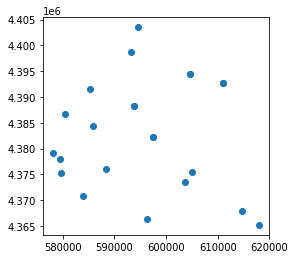

In [567]:
import geopandas as gpd

engines = get_engines()
enginelocs = gpd.GeoDataFrame(engines, geometry=gpd.points_from_xy(engines.lon, engines.lat), crs="EPSG:4326")
enginelocs = enginelocs.to_crs(epsg='26916')
enginelocs.plot()

Uh...sure...maybe that would make more sense if we start to put together a map...

For that, we'll use some data from https://maps.indiana.edu/layerGallery.html?category=localBoundaries to get geography data about Brandywine and Sugar Creek townships.

In [568]:
townships = gpd.read_file(r'Local_Boundaries_Minor_Civil_Divisions/Minor_Civil_Divisions_IN.shp')
is_shelby = townships['Cnty_Name']=="Shelby"
shelby_townships = townships[is_shelby]
shelby_townships

,COUNTY,MCD,COUSUBFP,Cnty_Name,MCD_Name,geometry
591,145,065,78578,Shelby,Van Buren,"POLYGON ((608406.879 4395113.404, 608463.486 4..."
592,145,015,31270,Shelby,Hanover,"POLYGON ((609300.782 4395131.609, 610890.858 4..."
594,145,040,50994,Shelby,Moral,"POLYGON ((599544.164 4394941.052, 599576.671 4..."
616,145,060,77642,Shelby,Union,"POLYGON ((612697.158 4387093.343, 612698.246 4..."
617,145,010,07102,Shelby,Brandywine,"POLYGON ((601791.567 4386919.094, 602965.769 4..."
618,145,035,47052,Shelby,Marion,"POLYGON ((611075.116 4387039.161, 611136.882 4..."
621,145,055,73952,Shelby,Sugar Creek,"POLYGON ((592379.732 4385008.098, 594784.434 4..."
637,145,005,00568,Shelby,Addison,"POLYGON ((606817.863 4379055.648, 606881.957 4..."
648,145,030,43398,Shelby,Liberty,"POLYGON ((611839.832 4375904.621, 614405.207 4..."
649,145,020,33070,Shelby,Hendricks,"POLYGON ((599991.840 4375690.913, 600018.444 4..."


In [569]:
in_jurisdiction = (shelby_townships['MCD_Name'] == "Brandywine") | (shelby_townships['MCD_Name'] == "Sugar Creek")
jurisdiction = shelby_townships[in_jurisdiction]
jurisdiction.head()

,COUNTY,MCD,COUSUBFP,Cnty_Name,MCD_Name,geometry
617,145,010,07102,Shelby,Brandywine,"POLYGON ((601791.567 4386919.094, 602965.769 4..."
621,145,055,73952,Shelby,Sugar Creek,"POLYGON ((592379.732 4385008.098, 594784.434 4..."


...and an eyeball test...

<AxesSubplot:>

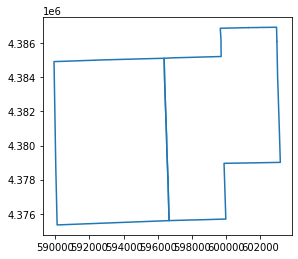

In [570]:
import matplotlib.pyplot as plt
jurisdiction.exterior.plot()


The shape is right... But, to be sure, we need some more landmarks...like maybe roads...

An astonishing amount of road data is available from https://maps.indiana.edu/layerGallery.html?category=Streets.

...so much so that we should just load the data that's within a reasonable distance around our target jurisdiction:

In [571]:
roads = gpd.read_file(
r'Streets_Roads_INDOT_2015/Roads_2015_INDOT_IN.shp',
bbox = jurisdiction.dissolve().envelope.buffer(1500),
)
roads.head()


,ROUTE_NAME,ALTERNATE_,ALTERNATE1,COUNTY_COD,CITY_CODE,RTEL,RAMP_CODE,SECTION_NO,ROUTE_ID,SHAPE_Leng,JURISDICTI,geometry
0,3RD ST,None,None,73,0770,0665,0000,01,57307700665000001,246.503623,City Street,"LINESTRING Z (604218.160 4374565.745 0.000, 60..."
1,HALE RD,None,None,73,0770,0813,0000,01,57307700813000001,451.005367,City Street,"LINESTRING Z (603699.935 4374301.000 0.000, 60..."
2,I-74 109D,None,RAMP,73,0000,0740,109D,01,17300000740109D01,398.373686,Interstate,"LINESTRING Z (601183.490 4382324.980 0.000, 60..."
3,I-74,None,INC,73,0000,0740,0000,01,17300000740000001,36781.198926,Interstate,"LINESTRING Z (589881.950 4391507.985 0.000, 58..."
4,JOHNSON ST,None,None,73,0444,0002,0000,01,57304440002000001,123.734559,City Street,"LINESTRING Z (597708.250 4382625.855 0.000, 59..."


OK, those look like road names we know from the area...how about a visualization?

<AxesSubplot:>

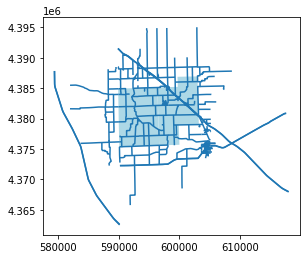

In [572]:
fig, ax = plt.subplots()
jurisdiction.plot(ax=ax, color='lightblue')
roads.plot(ax=ax)

That looks familiar. We can pick out features like Shelbyville, I74, I65, and Fairland. And our two townships look right in comparison to those features.

OK, now we can look back at our data about engines in context...(with some CRS translation thrown in to get all the data sharing a common coordinate system)

<AxesSubplot:>

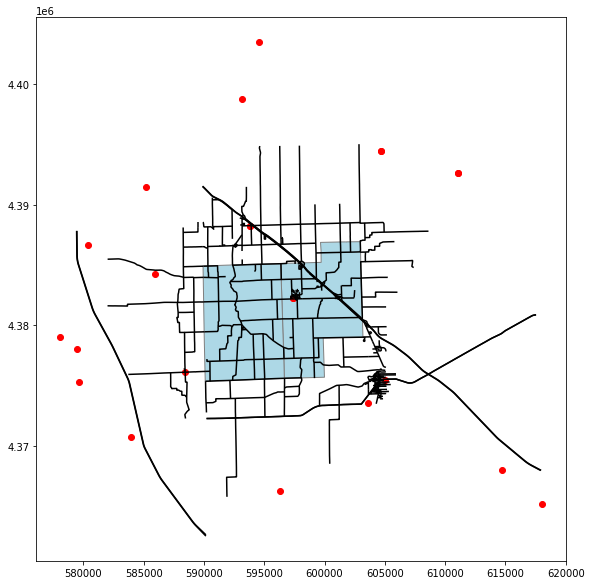

In [573]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
jurisdiction.plot(ax=ax, color='lightblue', edgecolor='grey')
roads.plot(ax=ax, color='black')
enginelocs.plot(ax=ax, color='red')

...then the magic happens...

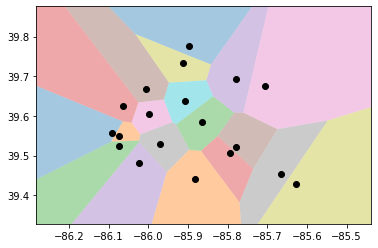

In [455]:
import visualize_voronoi as vv
vv.visualize(engines)

...except that's not easy to layer onto the map we worked so hard to assemble...so, we back up and use scipy.spatial.Voronoi and helpers more directly...

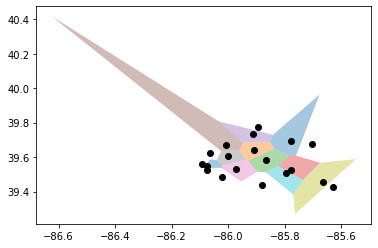

In [561]:
# from scipy.spatial.qhull import Voronoi
# from shapely.geometry import Polygon
# from shapely.geometry import LineString, MultiPoint, Point, MultiPolygon
# from shapely.ops import polygonize,unary_union

import numpy as np
import matplotlib.pyplot as plt
from shapely.ops import polygonize, unary_union
from shapely.geometry import LineString, MultiPolygon, MultiPoint, Point
from scipy.spatial import Voronoi

points = list(set(engines[['lon','lat']].itertuples(index=False, name=None)))
points = np.array(points)
vor = Voronoi(points)

lines = [
    LineString(vor.vertices[line])
    for line in vor.ridge_vertices if -1 not in line
]

convex_hull = MultiPoint([Point(i) for i in points]).convex_hull.buffer(2)
result = MultiPolygon(
    [poly.intersection(convex_hull) for poly in polygonize(lines)])
# result = MultiPolygon(
#     [p for p in result.geoms]
#     + [p for p in convex_hull.difference(unary_union(result))])

plt.plot(points[:,0], points[:,1], 'ko')
for r in result.geoms:
    plt.fill(*zip(*np.array(list(
        zip(r.boundary.coords.xy[0][:-1], r.boundary.coords.xy[1][:-1])))),
        alpha=0.4)
plt.show()

Now, let's plot it all on one map:

<AxesSubplot:>

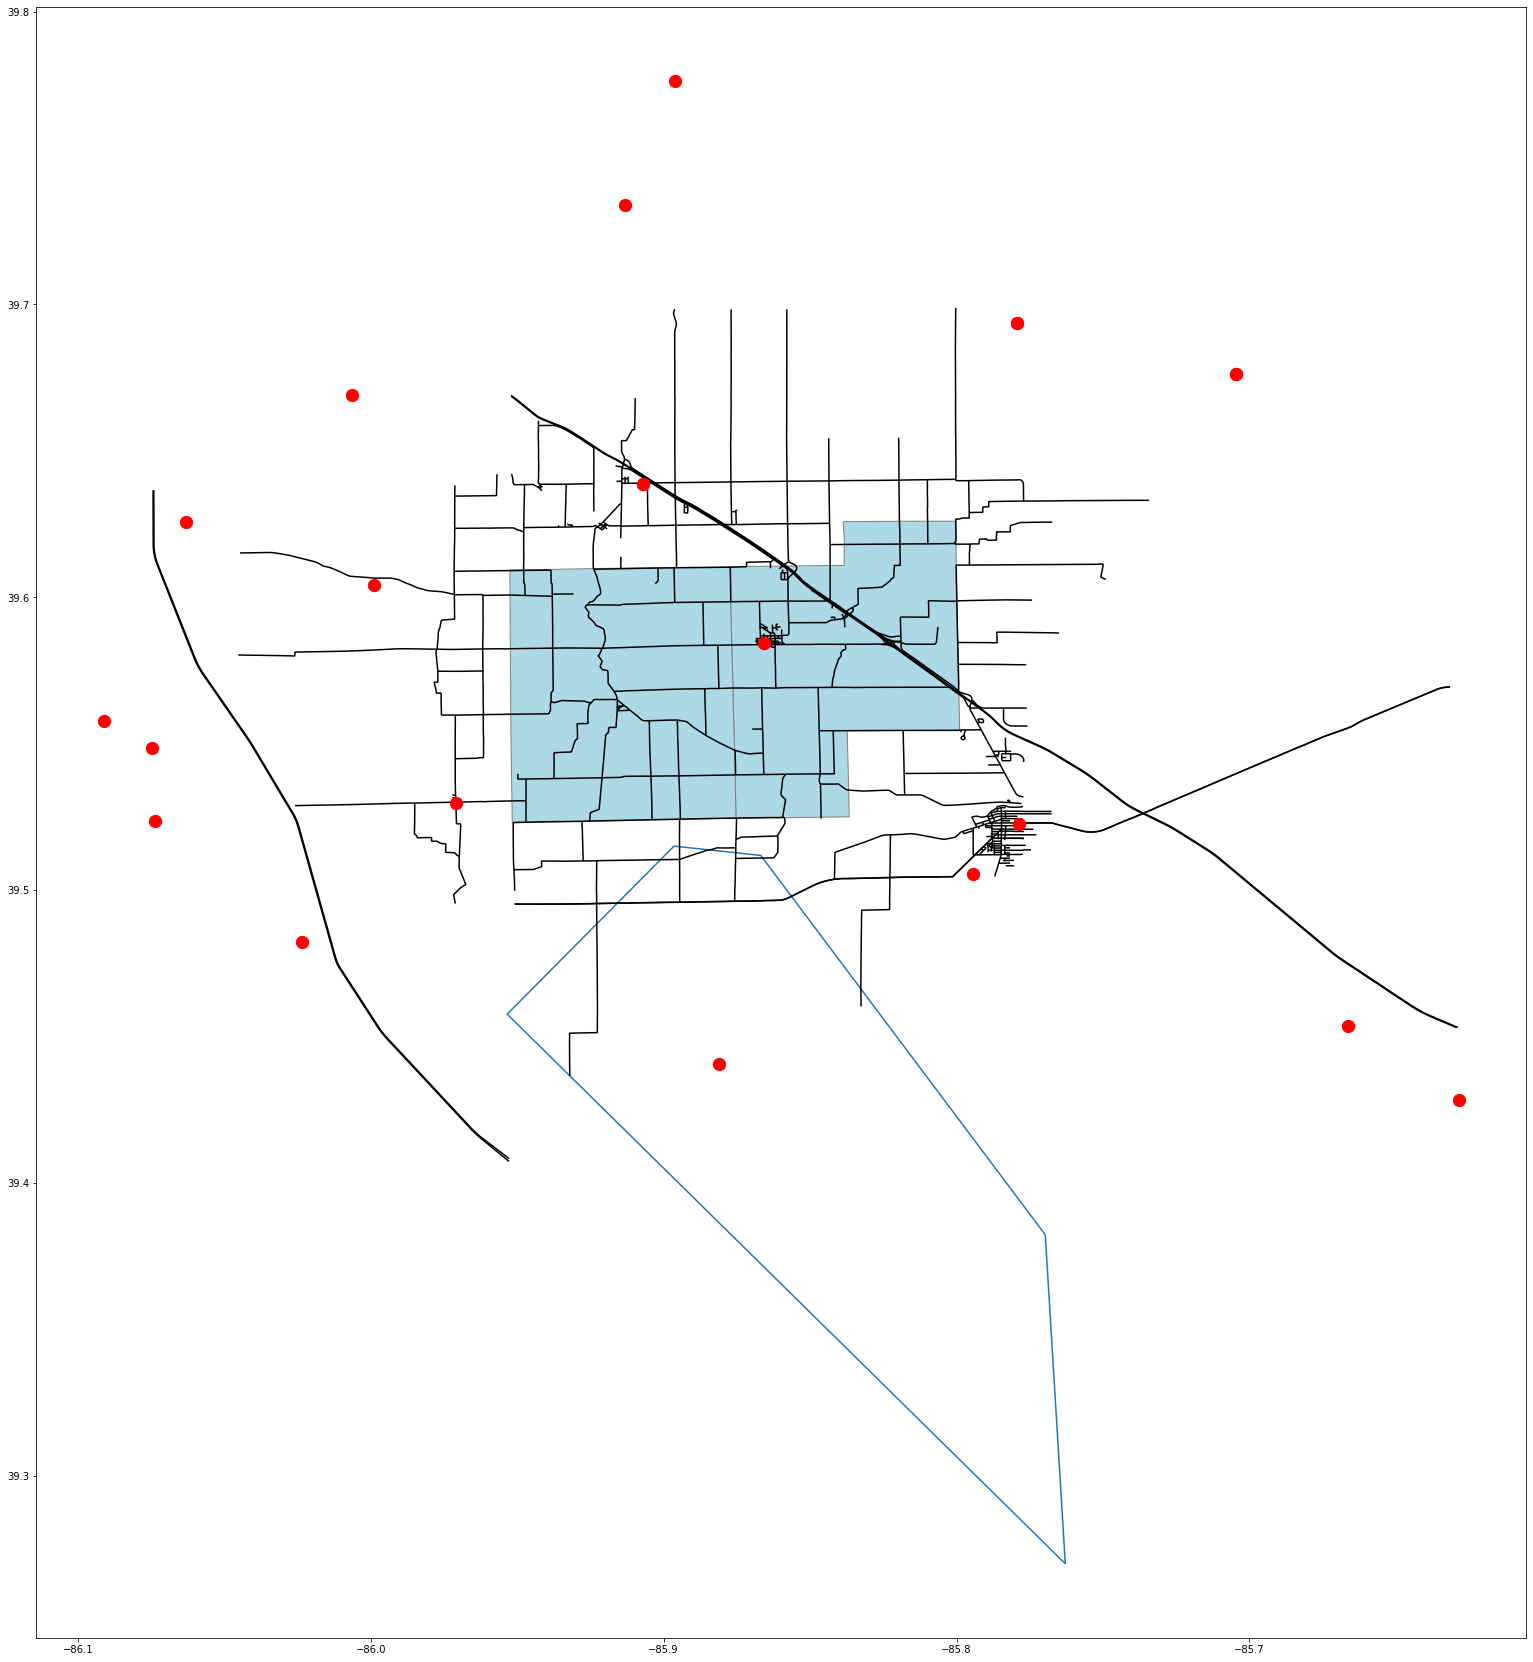

In [528]:
fig, ax = plt.subplots()
fig.set_size_inches(30, 30)
jurisdiction.to_crs(epsg=4326).plot(ax=ax, color='lightblue', edgecolor='grey')
roads.to_crs(epsg=4326).plot(ax=ax, color='black', zorder=5)
enginelocs.plot(ax=ax, color='red', markersize=150, zorder=10)
gpd.GeoSeries(engine_regions).exterior.plot(ax=ax)




In [ ]:
lt.subplots()
fig.set_size_inches(30, 30)
jurisdiction.to_crs(epsg=4326).plot(ax=ax, color='orange')
streets.to_crs(epsg=4326).plot(ax=ax, color='grey')
enginelocs.plot(ax=ax, color='red', markersize=150, zorder=10)
gpd.GeoSeries(data).exterior.plot(ax=ax)




<AxesSubplot:>

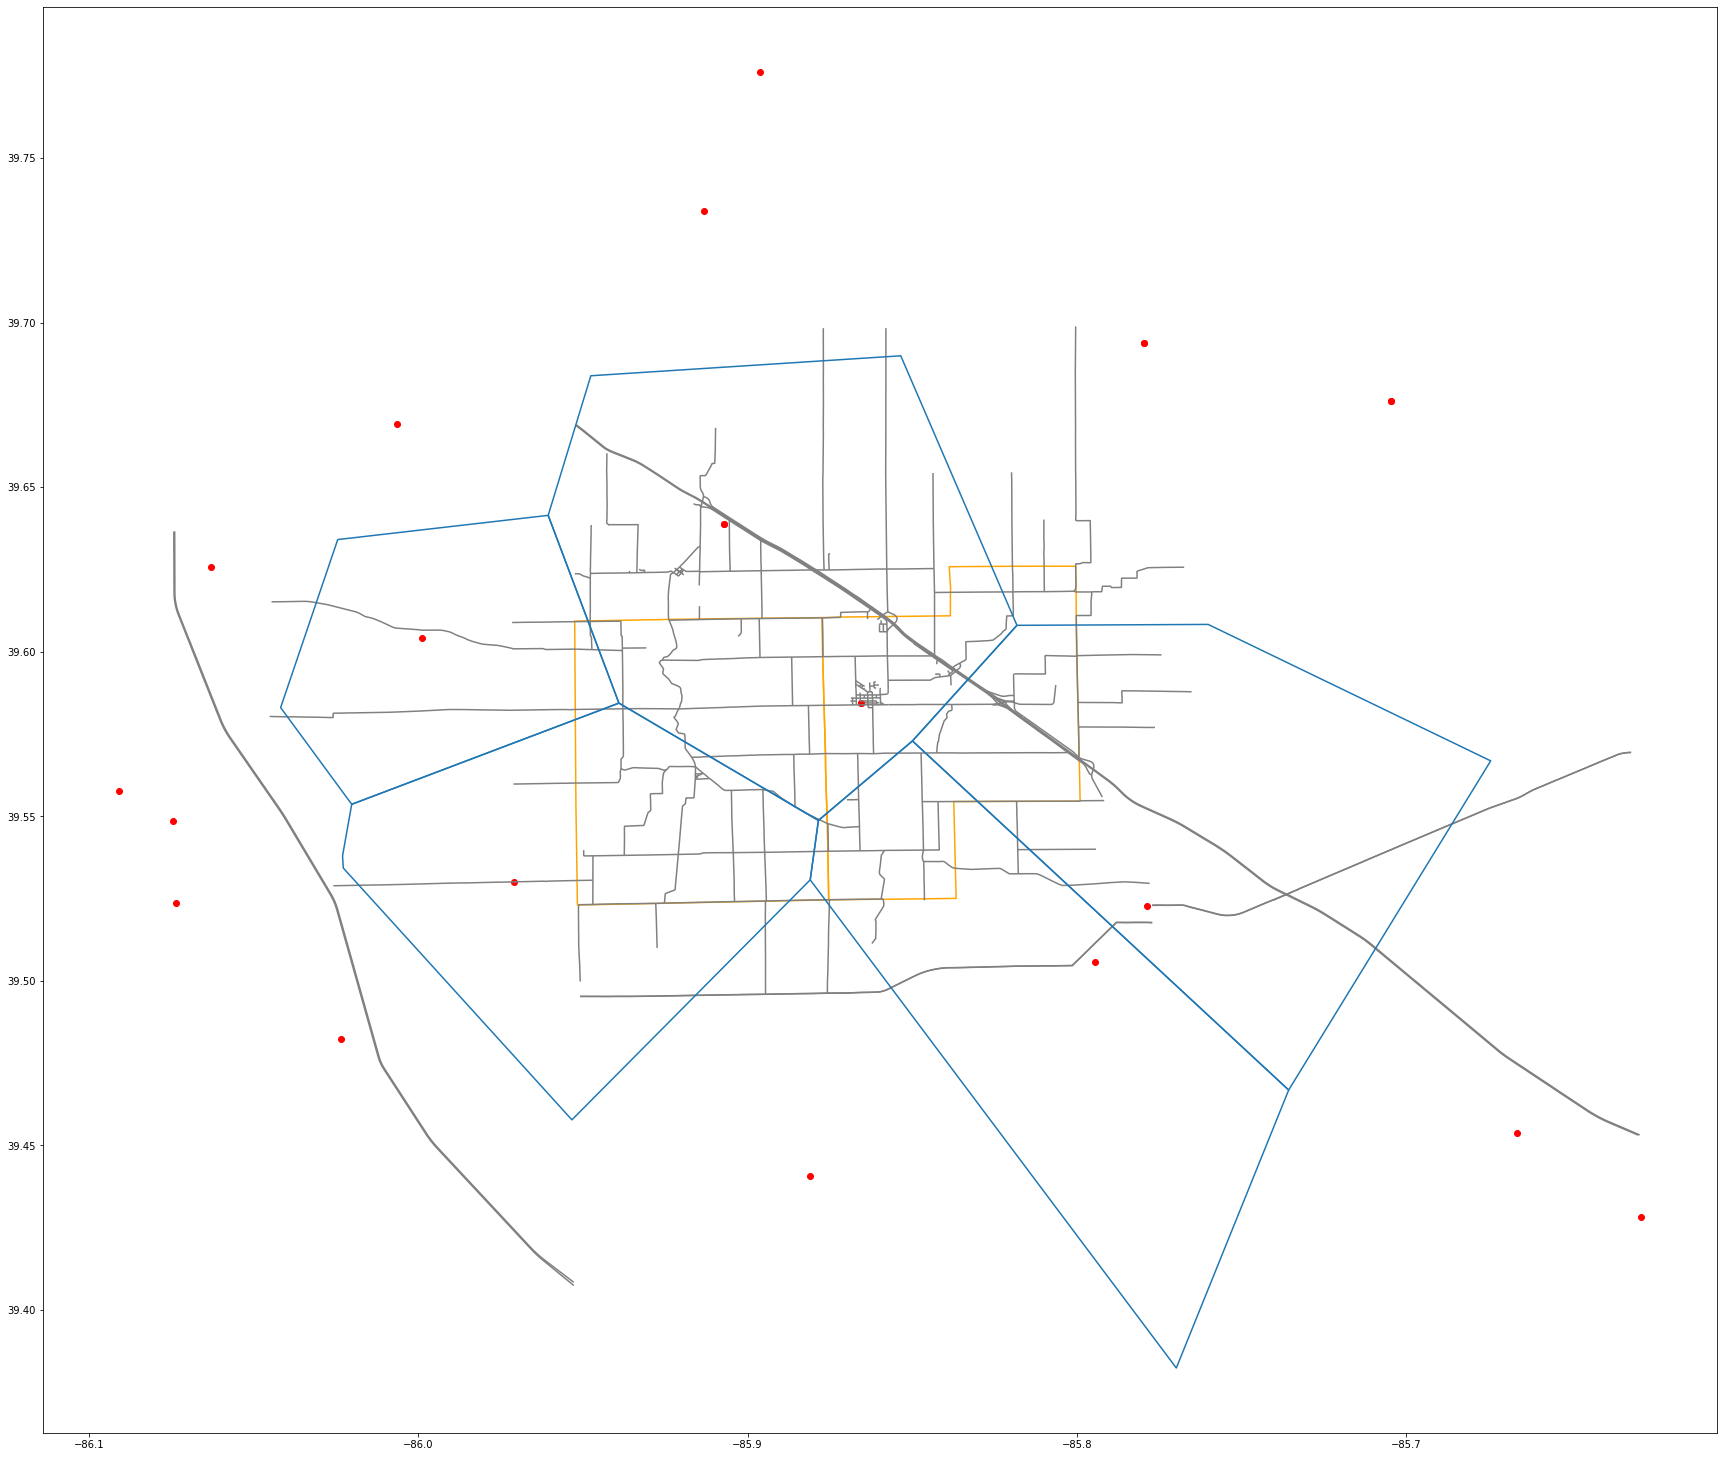

In [358]:
points = []
non_fland_engines = engines[2:]
points = list(set(non_fland_engines[['lon','lat']].itertuples(index=False, name=None)))

vor = Voronoi(points)

regions, vertices = vv.voronoi_finite_polygons_2d(vor)
poly1 = vertices[regions[1]]
data1 = Polygon(poly1)
poly2 = vertices[regions[7]]
data2 = Polygon(poly2)
poly3 = vertices[regions[9]]
data3 = Polygon(poly3)
poly4 = vertices[regions[10]]
data4 = Polygon(poly4)
poly5 = vertices[regions[14]]
data5 = Polygon(poly5)
fig, ax = plt.subplots()
fig.set_size_inches(30, 30)
jurisdiction.exterior.to_crs(epsg=4326).plot(ax=ax, color='orange')
streets.to_crs(epsg=4326).plot(ax=ax, color='grey')
enginelocs.plot(ax=ax, color='red')
gpd.GeoSeries(data1).exterior.plot(ax=ax)
gpd.GeoSeries(data2).exterior.plot(ax=ax)
gpd.GeoSeries(data3).exterior.plot(ax=ax)
gpd.GeoSeries(data4).exterior.plot(ax=ax)
gpd.GeoSeries(data5).exterior.plot(ax=ax)
